# Summary_plotter_days_per_year.ipynb

#### Robert Peal January 2025

- Plot summary of sensitivity of number of westerly days per year

In [1]:
import xarray as xr
import sys
sys.path.append("/home/atuin/c104fa/c104fa10/utils")
import tctools2 as tct
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import pyproj
pyproj.datadir.set_data_dir("/home/atuin/c104fa/c104fa10/software/conda/envs/atmos_sci/share/proj") ## This line is needed to allow geopandas imports
# import cartopy.crs as ccrs
# import pandas as pd
import pickle

/home/atuin/c104fa/c104fa10/software/conda/envs/atmos_sci/lib/python3.9/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


In [2]:
dataPath = "/home/atuin/c104fa/c104fa10/eeaWesterliesPaper/mjoWesterlyDays/sensitivity/data/mjoClassFracs."
totalLoc = "/home/atuin/c104fa/c104fa10/eeaWesterliesPaper/mjoWesterlyDays/sensitivity/data/mjoClassTotals.pkl"

directions = [40,45,50]
sizes = [750,1000,1500]
thresholds = [60,70,80] 

#### Create a dataset with the different parameter values as coords

In [30]:
data = []

for dir in directions:
    for size in sizes:
        for threshold in thresholds:
            filePath = f"{dataPath}dir.{dir}_thresh.{threshold}_size.{size}.nc"
            ds = xr.open_dataset(filePath)

            ds = ds.drop_vars(["level","quantile"])

            ds = ds.expand_dims(dir=1).assign_coords(dir=[dir])#("dir",[dir]))
            ds = ds.expand_dims(size=1).assign_coords(size=[size])#("size",[size]))
            ds = ds.expand_dims(threshold=1).assign_coords(threshold=[threshold])#("threshold",[threshold]))

            data.append(ds)

ds = xr.combine_by_coords(data)

## Processing to make it in the form of WMTE days per month
with open(totalLoc, "rb") as f:
    seasonTotals = pickle.load(f)

seasons = ["JF","MAM","JJAS","OND"]

years = np.arange(1980,2023)
nyears = len(years)

daysPerMonth = ds.copy(deep=True)

for seasonix, season in enumerate(seasons):
    for MJOix, MJO_class in enumerate(ds["MJO_class"].values):

        seasonClassNumberDays = seasonTotals[season][MJO_class] # number of days in that class and season

        nmonths = len(season)

        seasonClassNumberDaysPerMonth = seasonClassNumberDays / (nmonths*nyears) # average number of days in that class and season per month

        daysPerMonth[season].loc[:,:,:,MJO_class] *=  seasonClassNumberDaysPerMonth

daysPerMonth = daysPerMonth.sum(dim="MJO_class")

daysPerMonth

<xarray.Dataset>
Dimensions:    (longitude: 497, latitude: 309, threshold: 3, size: 3, dir: 3)
Coordinates:
  * longitude  (longitude) float32 -22.0 -21.75 -21.5 ... 101.5 101.8 102.0
  * latitude   (latitude) float32 40.0 39.75 39.5 39.25 ... -36.5 -36.75 -37.0
  * dir        (dir) int64 40 45 50
  * size       (size) int64 750 1000 1500
  * threshold  (threshold) int64 60 70 80
Data variables:
    JF         (threshold, size, dir, latitude, longitude) float64 4.128 ... ...
    MAM        (threshold, size, dir, latitude, longitude) float64 3.256 ... ...
    JJAS       (threshold, size, dir, latitude, longitude) float64 2.576 ... ...
    OND        (threshold, size, dir, latitude, longitude) float64 3.868 ... ...

#### Plot the average number of days per month with WMTE in the EEA box

In [ ]:
lonMin = 25
lonMax = 35
latMin = -12
latMax = -8

box = daysPerMonth.sel(latitude=slice(latMax,latMin),longitude=slice(lonMin,lonMax))
boxAvg = box.mean(dim=["longitude","latitude"]) # Mean value in the box

monthAvg = boxAvg["JF"] # Data for for Jan/ Feb

Text(0.5, 1.0, 'JF WMTE Days per month in EEA box (25-35$\\degree$E,-12--8$\\degree$N)')

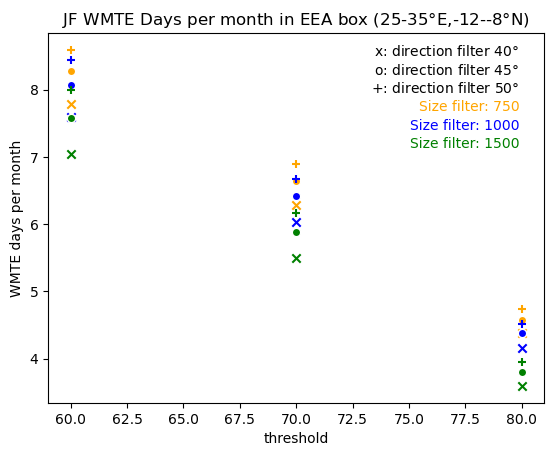

In [17]:
directions = monthAvg["dir"].values
thresholds = monthAvg["threshold"].values
sizes = monthAvg["size"].values

markers = ["x","o","+"]
colours = ["orange", "blue", "green"]

fig,ax = plt.subplots(1,1)

for dirix,dir in enumerate(directions):

    for sizeix,size in enumerate(sizes):
        data= monthAvg.sel(dir=dir,size=size)

        data.plot.scatter(x="threshold",marker=markers[dirix],c=colours[sizeix],ax=ax)#,title=None)

plt.title(None)
plt.ylabel("WMTE days per month")
textOriginY = 0.95
textIntY = 0.05
textOriginX = 0.95
ypos = textOriginY
for dirix,dir in enumerate(directions):
    ax.text(s=f"{markers[dirix]}: direction filter {dir}$\degree$",x=textOriginX,y=ypos,va="center",ha="right",transform=ax.transAxes)
    ypos -= textIntY

for sizeix,size in enumerate(sizes):
    ax.text(s=f"Size filter: {size}",x=textOriginX,y=ypos,va="center",ha="right",transform=ax.transAxes,c=colours[sizeix])
    ypos -= textIntY

plt.title(f"JF WMTE Days per month in EEA box ({lonMin}-{lonMax}$\degree$E,{latMin}-{latMax}$\degree$N)")

#### Rate of change for the different variables

In [18]:
## Difference divided by the average change in each variable
dirDifferential = (monthAvg.diff("dir").values).flatten() / 5
sizeDifferential = (monthAvg.diff("size").values).flatten() / 375
threshDifferential = (monthAvg.diff("threshold").values).flatten() /10

diffs = [dirDifferential,sizeDifferential,threshDifferential]
diffs

[array([0.0976911 , 0.06294084, 0.09365387, 0.07449868, 0.10688666,
        0.08087485, 0.06979747, 0.05127623, 0.07774849, 0.04912082,
        0.07485903, 0.05729205, 0.04142338, 0.03060959, 0.04567082,
        0.02530446, 0.04221414, 0.02980548]),
 array([-0.00051548, -0.00056931, -0.0004152 , -0.00145349, -0.00127706,
        -0.00119204, -0.0006896 , -0.00058359, -0.00061233, -0.00141016,
        -0.00144869, -0.00133974, -0.00058003, -0.00052339, -0.00059413,
        -0.00149923, -0.00154532, -0.0014853 ]),
 array([-0.14949117, -0.16343799, -0.16927029, -0.15602082, -0.16397351,
        -0.17666244, -0.15439592, -0.17040973, -0.18220113, -0.19162857,
        -0.20581562, -0.21614894, -0.1875196 , -0.20355844, -0.21546662,
        -0.1908595 , -0.20718194, -0.22092523])]

#### Now we make a boxplot. Each point consists of the values of the rate of change with for different parameter combinations

Text(0.5, 1.0, 'Differential of JF WMTE Days per month wrt diff params.\nEEA box (25-35$\\degree$E,-12--8$\\degree$N  )')

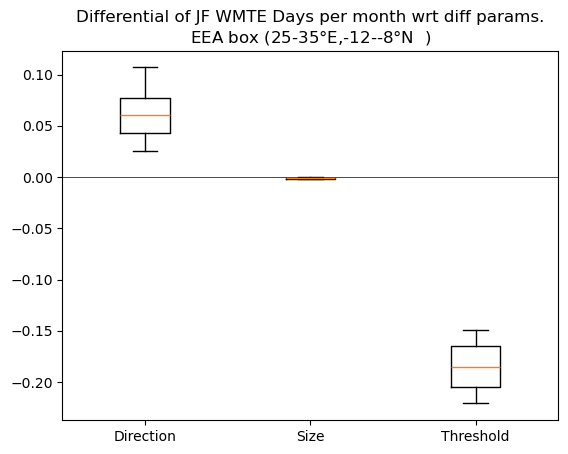

In [19]:
plt.boxplot(diffs,labels=["Direction","Size","Threshold"])
plt.axhline(0,c="k",lw="0.5")
plt.title(f"Differential of JF WMTE Days per month wrt diff params.\nEEA box ({lonMin}-{lonMax}$\degree$E,{latMin}-{latMax}$\degree$N  )")

#### Spatial map of rate of change

In [31]:
dirDifferential = (daysPerMonth.diff("dir")).mean(dim=["dir","size","threshold"]) / 5
sizeDifferential = (daysPerMonth.diff("size")).mean(dim=["dir","size","threshold"]) / 375
threshDifferential = (daysPerMonth.diff("threshold")).mean(dim=["dir","size","threshold"]) / 10

maps = [dirDifferential,sizeDifferential,threshDifferential]

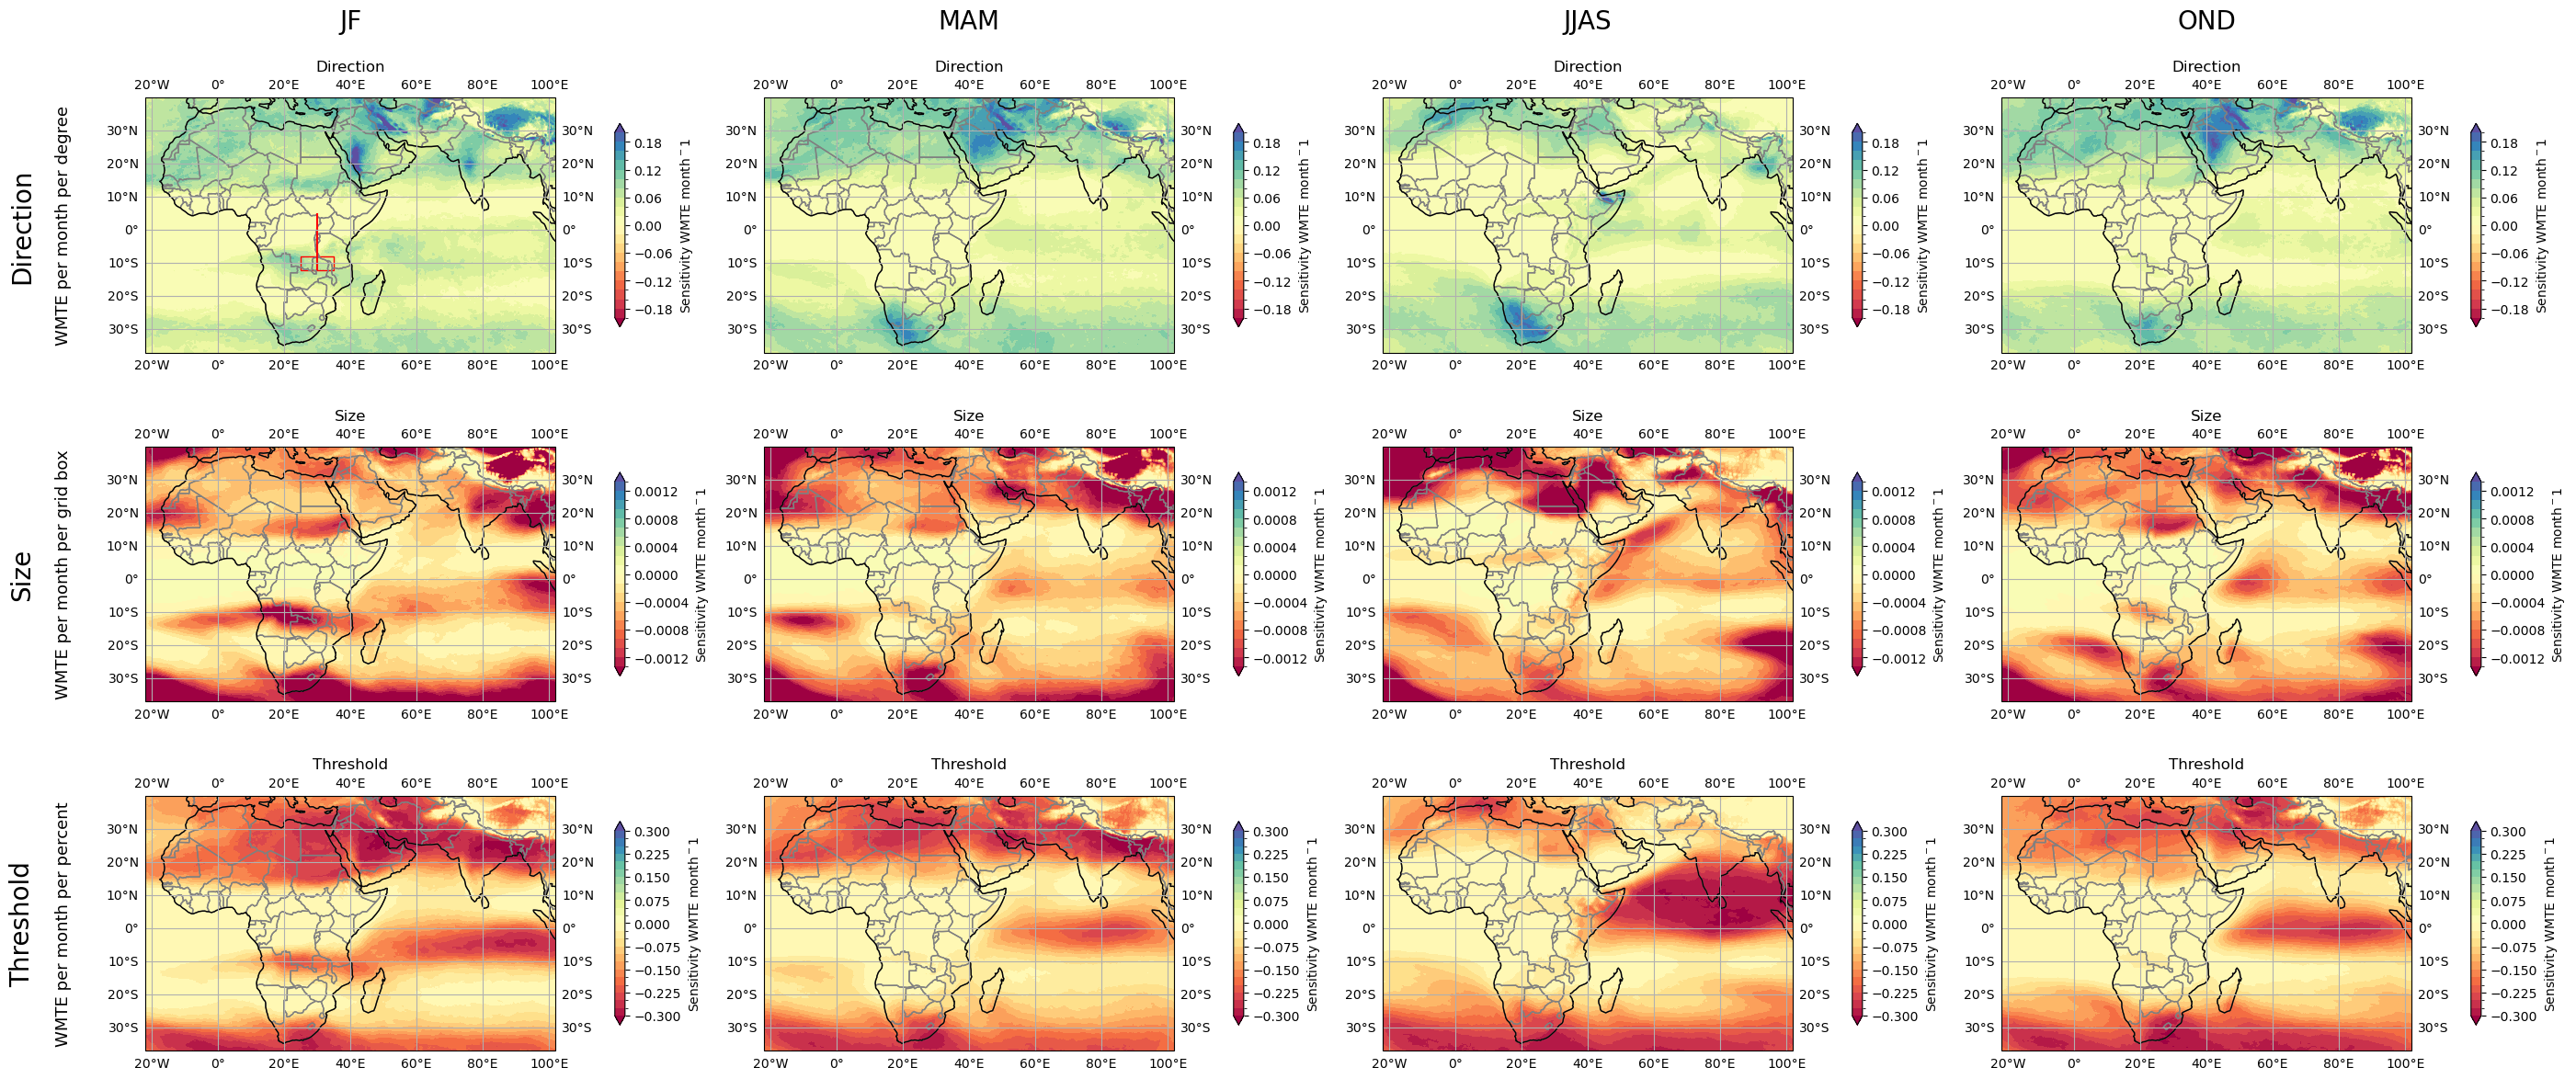

In [32]:
fig,axs = tct.new_map_axes(nrows=3,ncols=4)

names = ["Direction","Size","Threshold"]
units = ["per degree","per grid box","per percent"]

cmap = plt.get_cmap("Spectral")

levels = [np.arange(-1,1.1,0.1) / 5, np.arange(-0.5,0.55,0.05) / 375, np.arange(-3,3.25,0.25) / 10]

for seasonix,season in enumerate(seasons):

    col = axs[:,seasonix]
    col[0].text(s=season,x=0.5,y=1.3,size=20,transform=col[0].transAxes,ha="center",va="center")

    for iax, ax in enumerate(col):
        name = names[iax]
        im=maps[iax][season].plot.contourf(ax=ax,cmap=cmap,levels=levels[iax],extend="both",cbar_kwargs=dict(shrink=0.6,label=f"Sensitivity WMTE month$^{-1}$"))
        ax.set_title(f"{name}")

for iax,ax in enumerate(axs[:,0]):
    ax.text(s=f"{names[iax]}",x=-0.3,y=0.5,size=20,transform=ax.transAxes,ha="center",va="center",rotation=90)
    ax.text(s=f"WMTE per month {units[iax]}",x=-0.2,y=0.5,size=13,transform=ax.transAxes,ha="center",va="center",rotation=90)

# Parameters: (x, y) for bottom-left corner, width, height
rectangle = Rectangle((lonMin,latMin), lonMax-lonMin, latMax-latMin, ec='red', fill=False)

# Add the rectangle to the axis
axs[0,0].add_patch(rectangle)
axs[0,0].vlines(30,5,-12,color="red")


#### Sensitivity

inverse of the differential

In [35]:
dirSensitivity = abs(5/(daysPerMonth.diff("dir")).mean(dim=["dir","size","threshold"]))
sizeSensitivity  = abs(375/(daysPerMonth.diff("size")).mean(dim=["dir","size","threshold"]))
threshSensitivity  = abs(10/(daysPerMonth.diff("threshold")).mean(dim=["dir","size","threshold"]))

maps = [dirSensitivity ,sizeSensitivity ,threshSensitivity]

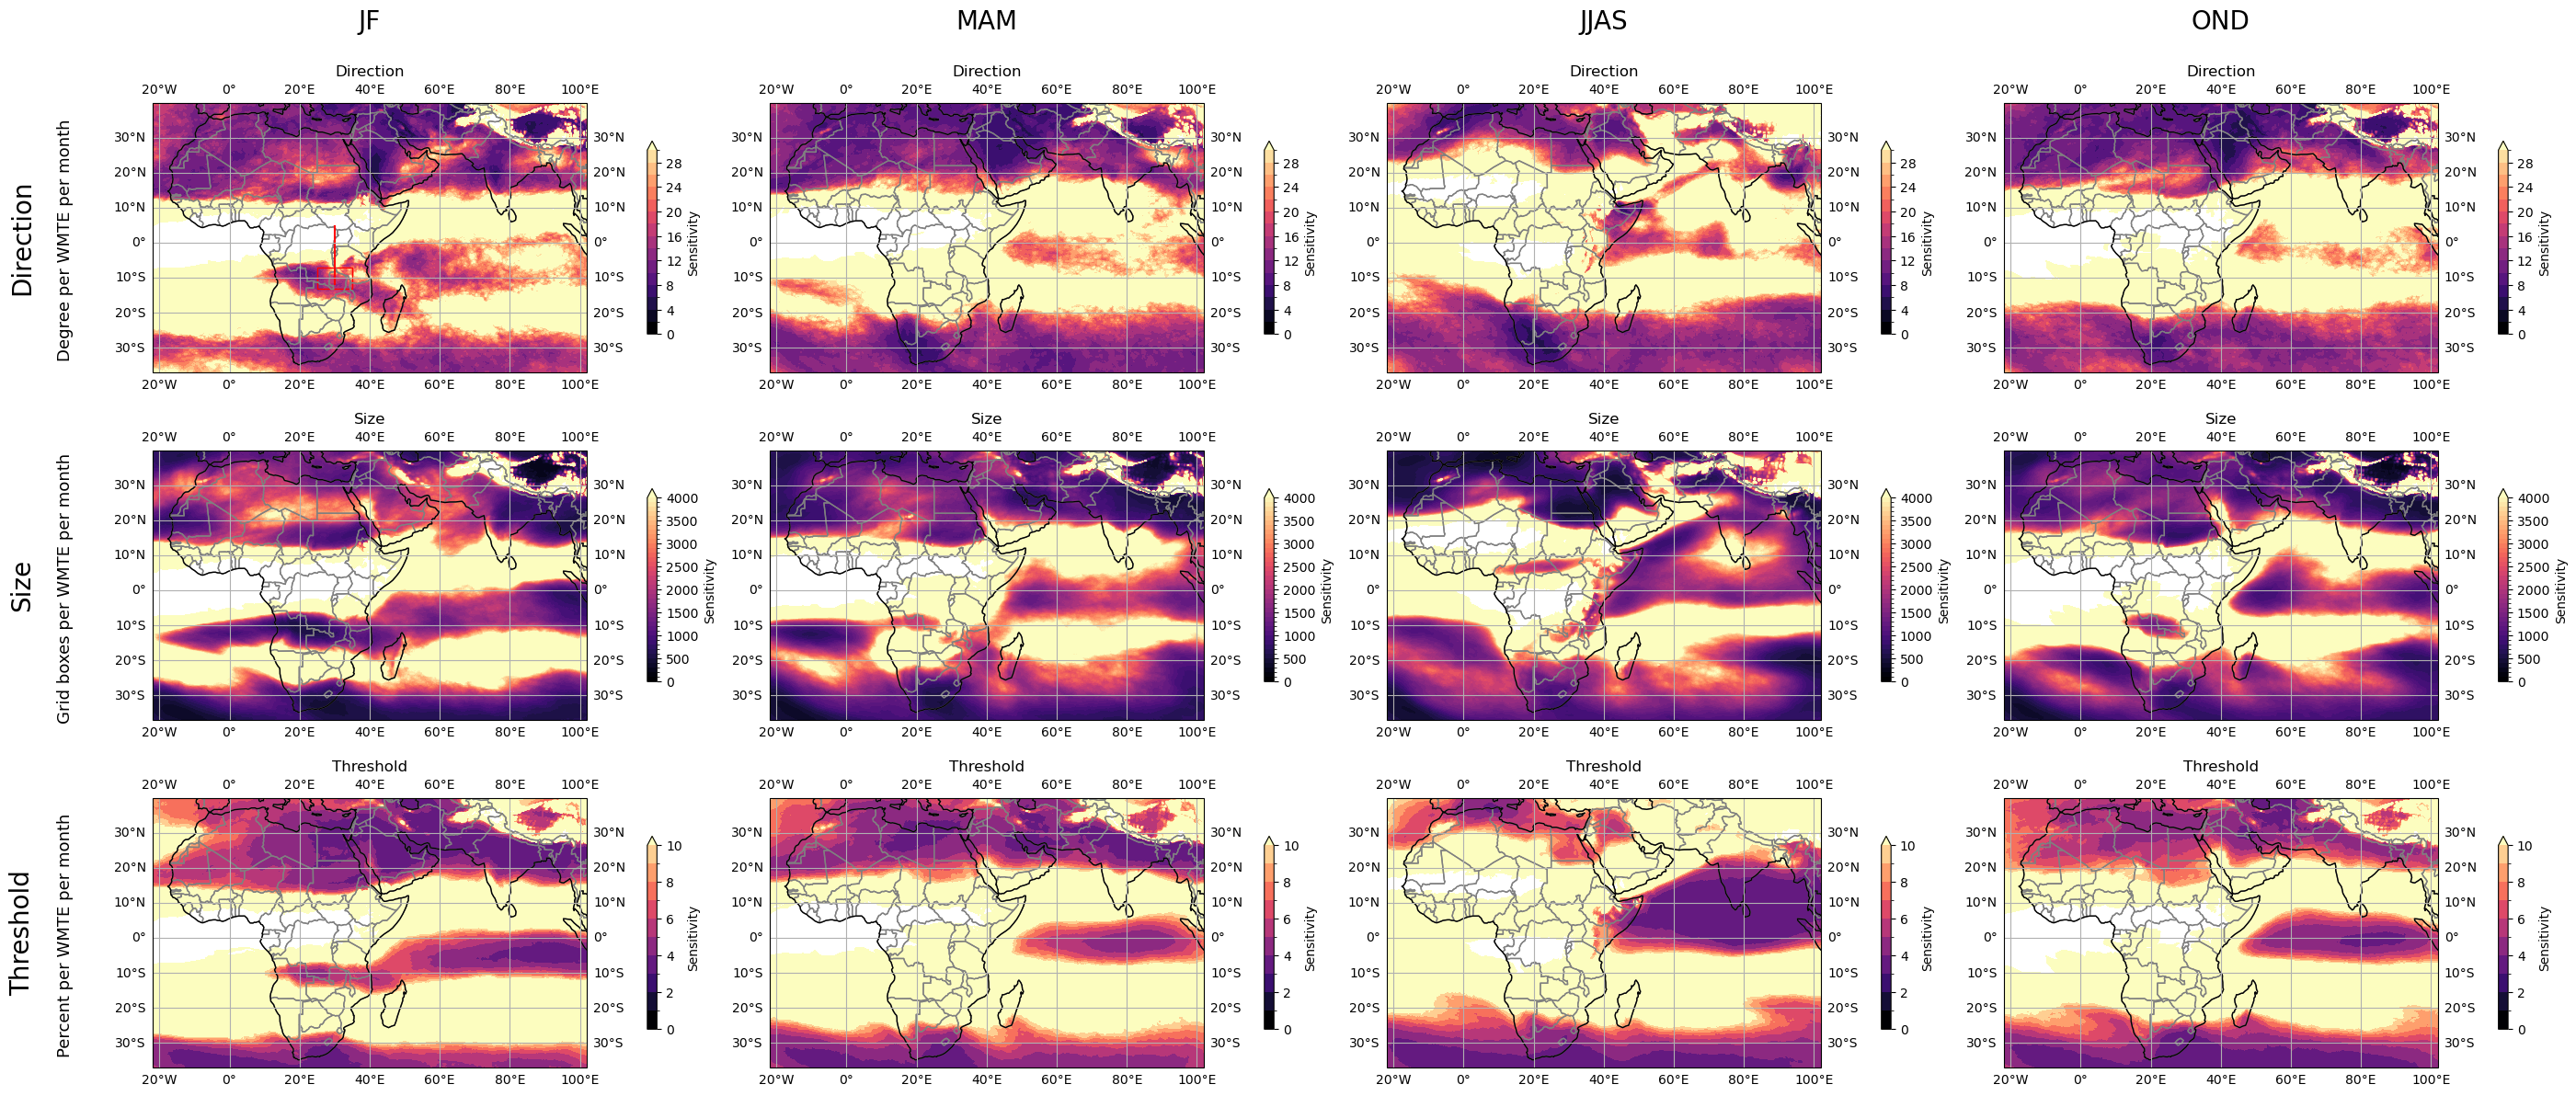

In [46]:
fig,axs = tct.new_map_axes(nrows=3,ncols=4)

names = ["Direction","Size","Threshold"]
units = ["Degree","Grid boxes","Percent"]

cmap = plt.get_cmap("magma")

levels = [np.arange(0,31,2), np.arange(0,4001,100), np.arange(0,11,1)]

for seasonix,season in enumerate(seasons):

    col = axs[:,seasonix]
    col[0].text(s=season,x=0.5,y=1.3,size=20,transform=col[0].transAxes,ha="center",va="center")

    for iax, ax in enumerate(col):
        name = names[iax]
        im=maps[iax][season].plot.contourf(ax=ax,cmap=cmap,extend="max",levels=levels[iax],cbar_kwargs=dict(shrink=0.6,label=f"Sensitivity"))
        ax.set_title(f"{name}")

for iax,ax in enumerate(axs[:,0]):
    ax.text(s=f"{names[iax]}",x=-0.3,y=0.5,size=20,transform=ax.transAxes,ha="center",va="center",rotation=90)
    ax.text(s=f"{units[iax]} per WMTE per month ",x=-0.2,y=0.5,size=13,transform=ax.transAxes,ha="center",va="center",rotation=90)

# Parameters: (x, y) for bottom-left corner, width, height
rectangle = Rectangle((lonMin,latMin), lonMax-lonMin, latMax-latMin, ec='red', fill=False)

# Add the rectangle to the axis
axs[0,0].add_patch(rectangle)
axs[0,0].vlines(30,5,-12,color="red")
